In [1]:
import cello_multiplier as cm
from onto_lib import general_ontology_tools as got
import pandas as pd

Unable to import pygraphviz. Visualization is disabled.
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\DOID.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\UBERON.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\CL.18-11-13.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\CVCL.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\EFO.17-01-30.obo ...


In [2]:
# !pip uninstall cello_multiplier --yes
# !pip install -U git+https://github.com/Bishop-Laboratory/CellO-MultiPLIER.git@test

In [3]:
B_df, Z_df, labels, per_gene_mean, per_gene_std = cm.get_default_mats()

In [4]:
#split 
from pathlib import Path
import json

split_dir = Path('split')



with open(split_dir / 'validation_bulk_experiments.json', 'r') as f:
    validation_egs = json.load(f)

with open(split_dir / 'pre_training_bulk_experiments.json', 'r') as f:
    train_egs = json.load(f)

In [5]:
train_Y_df = B_df[B_df.index.isin(train_egs)]
train_Y_df.shape

(3609, 258)

In [6]:
test_Y_df = B_df[B_df.index.isin(validation_egs)]
test_Y_df.shape

(684, 258)

In [7]:
# create list of samples by celltypes
from sklearn.preprocessing import MultiLabelBinarizer

sample2types = {
            sample: list(map(got.get_term_name, types_ids))
            for sample, types_ids in labels.items()
        }

types_per_b_samples = B_df.index.map(sample2types).values

mlb = MultiLabelBinarizer()
types_per_b_samples = B_df.index.map(sample2types).values

samples_dummies = pd.DataFrame(mlb.fit_transform(types_per_b_samples), columns=mlb.classes_, index=B_df.index)

celltypes = samples_dummies.columns.tolist()

type2samples = {
    type_: samples_dummies.index[samples_dummies[type_] == 1].tolist()
    for type_ in celltypes
}

In [8]:
types_sizes = samples_dummies.sum()
types_sizes

B cell                                             168
Bm4 B cell                                           2
CD14-low, CD16-positive monocyte                    14
CD14-positive monocyte                             302
CD14-positive, CD16-negative classical monocyte     11
                                                  ... 
umbilical artery endothelial cell                    1
unswitched memory B cell                             4
vascular associated smooth muscle cell               5
vein endothelial cell                               67
visceral muscle cell                                 5
Length: 317, dtype: int64

In [9]:
types_sizes.mean()

200.1198738170347

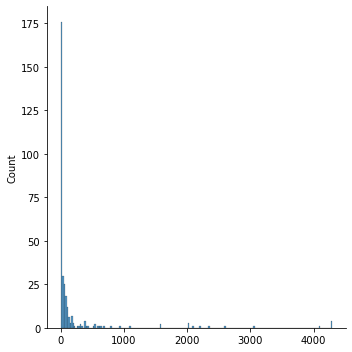

In [10]:
import seaborn as sns
sns.displot(types_sizes)

<AxesSubplot:ylabel='Count'>

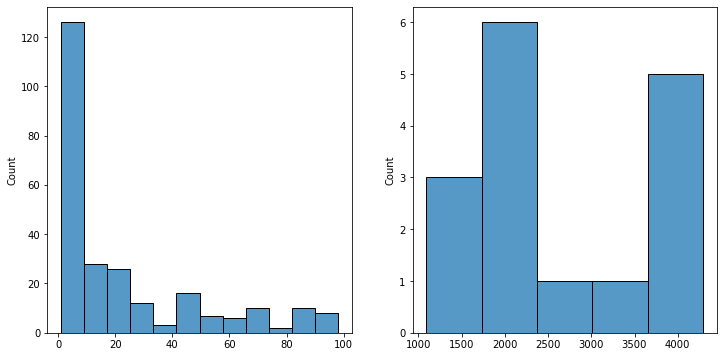

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12, 6))

sns.histplot(types_sizes[types_sizes < 100], ax=ax[0])
sns.histplot(types_sizes[types_sizes > 1000], ax=ax[1])

In [12]:
len(types_sizes)

317

In [13]:
types_sizes[types_sizes < 50]

Bm4 B cell                                          2
CD14-low, CD16-positive monocyte                   14
CD14-positive, CD16-negative classical monocyte    11
CD14-positive, CD16-positive monocyte              24
CD141-positive myeloid dendritic cell               7
                                                   ..
type II pneumocyte                                  5
umbilical artery endothelial cell                   1
unswitched memory B cell                            4
vascular associated smooth muscle cell              5
visceral muscle cell                                5
Length: 211, dtype: int64

In [14]:
# create target list for given cell type with 1 being that cell type and 0 being any other cell type
def set_target(celltype, type2samples, train_Y_df, test_Y_df, oversample, max_neg_pos_ratio):
    samplelist = type2samples[celltype]
    samplelist_train = [x for x in samplelist if x in train_Y_df.index.values]
    samplelist_test = [x for x in samplelist if x in test_Y_df.index.values]
    
    if(oversample == True and len(samplelist_train) > 0 and len(samplelist_test) >0):
        len_negative_train = len(train_Y_df)-len(samplelist_train)
        len_positive_train = len(samplelist_train)
        
        neg_pos_ratio = len_negative_train / len_positive_train
        
        # limit the max oversampling ratio
        neg_pos_ratio = min(neg_pos_ratio, max_neg_pos_ratio)
        
        if(neg_pos_ratio > 1):
            df_train = train_Y_df.loc[samplelist_train].sample(
                    n=int((neg_pos_ratio - 1) * len_positive_train),
                    replace=True, random_state=111
                )
            train_Y_df = train_Y_df.append(df_train)
    
    target_train = pd.Series(0,index = train_Y_df.index)
    target_train.loc[samplelist_train] = 1
    
    target_test = pd.Series(0,index = test_Y_df.index)
    target_test.loc[samplelist_test] = 1
    
    train_Y_transformed = scaler.transform(train_Y_df)
    test_Y_transformed = scaler.transform(test_Y_df)
    
    return(target_train.values, target_test.values, train_Y_transformed, test_Y_transformed )

In [15]:
# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(B_df)

In [16]:
def fscore(p, r):
    denom = p + r or 1

    return (p * r) / denom

In [17]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
import numpy as np
import warnings
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [18]:
types_with_data = types_sizes[types_sizes > 50].index.values
all_types = samples_dummies.columns

In [19]:
warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning

successful_celltypes = []
unsuccessful_celltypes = []
test_prs = []
test_precision = []
test_recall = []
fscores = []

for cell_type in tqdm(all_types):
    train_target, train_test, train_data, test_data = set_target(
        cell_type, type2samples, train_Y_df, test_Y_df, oversample=True,
        max_neg_pos_ratio=2
    )
    
    if(1 in train_target and 1 in train_test and 0 in train_target and 0 in train_test):
        # lasso penalty
        clf = LogisticRegression(solver = "liblinear",penalty = "l1",random_state=111 )
        
        clf.fit(train_data, train_target)
        target_pred = clf.predict(test_data)
        test_pr = metrics.average_precision_score(train_test, target_pred)
        test_precision += [precision_score(train_test, target_pred)]
        test_recall += [recall_score(train_test, target_pred)]
        fscores += [fscore(test_precision[-1], test_recall[-1])]
        successful_celltypes += [cell_type]
        #plot precision recall curve for celltype
#         disp = plot_precision_recall_curve(clf, test_data, train_test)
#         disp.ax_.set_title('2-class Precision-Recall curve '+str(cell_type)+': AP={0:0.2f}'.format(test_pr))
    else:
        unsuccessful_celltypes += [cell_type]
        
p = np.mean(test_precision)
r = np.mean(test_recall)
f = np.mean(fscores)
f_micro = fscore(p, r) 

report = pd.DataFrame(list(zip(successful_celltypes,test_precision,test_recall, fscores)),
                      columns = ["celltype","precision score","recall score","f score"])


In [20]:
print(f'precision: {p:.4f}, recall: {r:.4f}, f1: {f:.4f}, f1 micro avg: {f_micro:.4f}')

precision: 0.6574, recall: 0.5838, f1: 0.2862, f1 micro avg: 0.3092


In [21]:
report = pd.DataFrame(
    {
        "celltype": successful_celltypes,
        "precision score": test_precision,
        "recall score": test_recall,
        "f score": fscores
    })

report

,celltype,precision score,recall score,f score
0,B cell,0.722222,0.684211,0.351351
1,CD14-positive monocyte,0.526316,0.714286,0.303030
2,"CD14-positive, CD16-negative classical monocyte",0.000000,0.000000,0.000000
3,CD141-positive myeloid dendritic cell,0.000000,0.000000,0.000000
4,CD1c-positive myeloid dendritic cell,1.000000,0.333333,0.250000
...,...,...,...,...
204,type B pancreatic cell,0.666667,1.000000,0.400000
205,type II pneumocyte,0.000000,0.000000,0.000000
206,vascular associated smooth muscle cell,1.000000,1.000000,0.500000
207,vein endothelial cell,1.000000,1.000000,0.500000


## KNN classifier

In [22]:
B_df

,"1,REACTOME_TRNA_AMINOACYLATION","2,KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION","3,REACTOME_SIGNALING_BY_GPCR","4,REACTOME_INNATE_IMMUNE_SYSTEM","5,KEGG_HEMATOPOIETIC_CELL_LINEAGE","6,REACTOME_TRANSMEMBRANE_TRANSPORT_OF_SMALL_MOLECULES",LV 7,"8,KEGG_RIBOSOME","9,KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION","10,REACTOME_DEVELOPMENTAL_BIOLOGY",...,"249,REACTOME_SIGNALING_BY_GPCR","250,REACTOME_GPCR_DOWNSTREAM_SIGNALING",LV 251,"252,REACTOME_GPCR_LIGAND_BINDING",LV 253,"254,REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS",LV 255,"256,KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION",LV 257,"258,KEGG_LYSOSOME"
SRX890545,-0.047142,-0.061672,-0.130283,1.146374,-0.898703,0.003802,0.017951,0.039434,0.098819,0.090668,...,-0.058305,-0.078093,0.044096,-0.132987,-0.064891,-0.084233,-0.079715,0.031648,0.097951,-0.094273
SRX1067711,-0.138811,-0.072859,-0.141798,0.340086,-0.645768,-0.112054,-0.018228,0.100562,0.237286,0.130110,...,-0.106243,0.035508,0.029126,-0.212633,-0.118380,-0.079477,-0.020449,-0.055535,-0.110908,-0.107456
SRX1067710,0.151608,0.037346,-0.192227,0.235739,-0.367522,-0.075481,0.046992,0.261559,0.243077,0.117244,...,-0.033745,0.053268,0.095776,-0.122923,-0.077712,-0.034273,0.009063,-0.045567,-0.116538,-0.087277
SRX762971,-0.430337,0.065104,0.101707,0.161693,0.174591,0.056106,-0.022039,-0.074942,0.142305,-0.014810,...,0.054359,-0.017231,-0.059902,-0.021081,0.068002,0.000284,0.054229,0.099433,-0.046031,-0.195881
SRX762970,-0.631706,0.032056,0.143076,0.110677,0.055156,0.102357,-0.051572,-0.208738,0.033539,0.005028,...,0.120424,-0.132861,-0.044972,-0.029622,0.099259,0.006361,0.087683,0.114241,-0.135770,-0.305423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRX3399308,0.294573,-0.069644,-0.141022,0.539468,0.244524,-0.091735,0.011769,-0.125333,0.147355,0.024581,...,-0.038481,0.034995,0.038744,-0.150316,0.020215,-0.019632,-0.060539,0.006640,0.063724,-0.001279
SRX3399309,0.291303,-0.023101,-0.168163,0.677087,0.069541,-0.051337,0.037820,-0.156489,0.154689,0.026092,...,-0.051623,0.029143,0.038417,-0.141965,0.015350,-0.012548,-0.064325,-0.037800,0.047077,-0.011637
SRX3399310,0.355084,-0.005761,-0.149219,0.570555,0.218329,-0.101855,-0.023172,-0.195428,0.166614,0.058899,...,-0.056086,0.010201,-0.007310,-0.131150,0.080915,-0.007463,-0.021569,-0.039271,0.045941,-0.039003
SRX3399311,0.259266,-0.008042,-0.194899,0.645999,0.222681,-0.110187,0.011533,-0.170522,0.186274,0.012054,...,-0.010930,0.035821,0.050109,-0.188935,-0.036388,-0.005259,0.013963,-0.057372,-0.042020,0.017209


In [23]:
B_train_mat = train_Y_df.values
B_train_mat.shape

(3609, 258)

In [24]:
b_test_mat = test_Y_df.values

In [25]:
import scipy

def get_pearson_dists(vectors_a, vectors_b):
    vectors_pairs = zip(vectors_a, vectors_b)
    return [scipy.spatial.distance.correlation(a, b) for a, b in vectors_pairs]

def get_pearson_dists_mat(vectors_a, vectors_b):
    return np.array([
        # repeat the A vector for each B vector
        get_pearson_dists(np.array(vector_a[np.newaxis, :]).repeat(len(vectors_b), axis=0), vectors_b)
        for vector_a in tqdm(vectors_a)
    ])

### Predict all cell types for all test samples

In [26]:
test_2_train_dists = get_pearson_dists_mat(B_train_mat, b_test_mat)
test_2_train_dists.shape

(3609, 684)

In [27]:
train_samples, test_samples = train_Y_df.index.values, test_Y_df.index.values

In [28]:
# distances is n_train matrix X n_test
# with columns for test items and rows for train items
dists_df = pd.DataFrame(test_2_train_dists)
dists_df.columns = test_samples
dists_df.index = train_samples

In [29]:
def knn_classify(n_neighbours):
    # map each test item to it's closest train ones using dists matrix
    test_sample2closest_train = {
        # get the column for current test sample and find the index of raw the closest value
        sample_id: dists_df[sample_id].sort_values().index[:n_neighbours]
        for sample_id in test_samples
    }
    
    # predict each cell type just by looking N closest items for each test sample
    cell_types_y_predicted = pd.DataFrame([
        samples_dummies.loc[test_sample2closest_train[test_id]].sum()
        for test_id in test_samples
    ])
    
    proba = cell_types_y_predicted.values / n_neighbours

    cell_types_y_predicted[:] = proba
    
    return cell_types_y_predicted

### Calculate performance stats

In [30]:
true_test_dummies = samples_dummies.loc[test_samples]
true_test_dummies.shape

(684, 317)

In [31]:
warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning

all_scores = []
for n_neighbours in tqdm([1, 5, 10, 15, 20, 30, 40, 50, 100]):
    cell_types_y_predicted_proba = knn_classify(n_neighbours)
    
    for th in [0.1, .3, .5, .7, .9]:
        cell_types_y_predicted = cell_types_y_predicted_proba.copy()
        above_threshold = cell_types_y_predicted.values > th

        cell_types_y_predicted.values[above_threshold] = 1
        cell_types_y_predicted.values[~above_threshold] = 0

        successful_celltypes = []
        unsuccessful_celltypes = []
        test_precision = []
        test_recall = []
        f_scores = []

        # types_with_data or all_types
        for cell_type in all_types: 
            # cell type information from original data
            y_true = true_test_dummies[cell_type]
            y_predicted = cell_types_y_predicted[cell_type]

            # calculate precision only if we have predictions for this cell type
            if y_predicted.sum() > 0:
                test_precision.append(precision_score(y_true, y_predicted))

            # calculate recall only if we have true activations for this cell type
            if y_true.sum() > 0:
                test_recall.append(recall_score(y_true, y_predicted))

            # calculate f1 score only if we have precision and recall
            if y_predicted.sum() > 0 and y_true.sum() > 0:
                f_scores.append(fscore(test_precision[-1], test_recall[-1]))

        p = np.mean(test_precision)
        r = np.mean(test_recall)
        f = np.mean(f_scores)

        f_micro = fscore(p, r)
        
        all_scores.append({
            'knn': n_neighbours,
            'threshold': th,
            'p': p,
            'r': r,
            'f': f,
            'f_micro': f_micro
        })

#         print(f'knn: {n_neighbours}, th: {th}, precision: {p:.4f}, recall: {r:.4f}, f1: {f:.4f}, f1 micro avg: {f_micro:.4f}')
        
        if n_neighbours == 1:
            break

In [32]:
pd.DataFrame(all_scores).sort_values('f_micro', ascending=False).head(10)

,knn,threshold,p,r,f,f_micro
2,5,0.3,0.603041,0.625006,0.333724,0.306914
3,5,0.5,0.684536,0.533972,0.343408,0.299976
0,1,0.1,0.630964,0.559538,0.327677,0.296554
6,10,0.1,0.520731,0.664490,0.321020,0.291946
12,15,0.3,0.692241,0.478970,0.340975,0.283094
16,20,0.1,0.495992,0.657186,0.307211,0.282662
1,5,0.1,0.479860,0.681767,0.322101,0.281633
7,10,0.3,0.655497,0.493065,0.335310,0.281398
26,40,0.1,0.508486,0.591070,0.298809,0.273338
11,15,0.1,0.444837,0.692204,0.300355,0.270806


In [33]:
samplenames = [x for x in range(0,len(test_data))]
normalize = False
most_specific = True
    
sortby_pval = False
n_neighbours = 10

cell_types1 = cm.classify(
            B_df, 
            test_data,
            samplenames, 
            most_specific, 
            n_neighbours
        )


In [34]:
def predict_knn(test_data, cell_type):
    prediction = []
    samplenames = [x for x in range(0,len(test_data))]
    normalize = False
    most_specific = True
    sortby_pval = False
    n_neighbours = 10

    for name, cell_types in cell_types1.groupby(level=0):
        if(cell_type in cell_types.index.get_level_values(1)):
            pval = cell_types.xs(cell_type, level=1)["p_value"].values[0]
            
            if(pval <= 0.05):
                prediction += [1]
            else:
                prediction += [0]
        else:
            prediction += [0]
    
    return prediction

In [35]:
warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning

successful_celltypes = []
unsuccessful_celltypes = []
test_prs = []
test_precision = []
test_recall = []
fscores = []

for cell_type in tqdm(all_types):
    
    
    train_target, train_test, train_data, test_data = set_target(
        cell_type, type2samples, train_Y_df, test_Y_df, oversample=True,
        max_neg_pos_ratio=2
    )
    
    if(1 in train_target and 1 in train_test and 0 in train_target and 0 in train_test):
        # lasso penalty
        
        target_pred = predict_knn(test_data, cell_type)
        test_pr = metrics.average_precision_score(train_test, target_pred)
        test_precision += [precision_score(train_test, target_pred)]
        test_recall += [recall_score(train_test, target_pred)]
        fscores += [fscore(test_precision[-1], test_recall[-1])]
        successful_celltypes += [cell_type]
        #plot precision recall curve for celltype
#         disp = plot_precision_recall_curve(clf, test_data, train_test)
#         disp.ax_.set_title('2-class Precision-Recall curve '+str(cell_type)+': AP={0:0.2f}'.format(test_pr))
    else:
        unsuccessful_celltypes += [cell_type]
        
p = np.mean(test_precision)
r = np.mean(test_recall)
f = np.mean(fscores)
f_micro = fscore(p, r) 

report = pd.DataFrame(list(zip(successful_celltypes,test_precision,test_recall, fscores)),
                      columns = ["celltype","precision score","recall score","f score"])

In [36]:
print(f'precision: {p:.4f}, recall: {r:.4f}, f1: {f:.4f}, f1 micro avg: {f_micro:.4f}')

precision: 0.3100, recall: 0.3129, f1: 0.1305, f1 micro avg: 0.1557
